# **Морозова Дарья, ИАД-3**

# **Домашнее задание №1**
В этом домашнем задании вы познакомитесь с pytorch сами и сможете попрактиковаться в его применении.

План:
1.   Простейшие операции в pytorch
2.   Пишем Adam и применяем его к ручной модели
3.   Обучаем свою первую нейросеть


---



In [ ]:
import os
import sys
import math
import torch
import random
import numpy as np
from tqdm import tqdm
import torch.nn.functional as F
import torch.nn as nn
import matplotlib.pyplot as plt

# **Простейшие операции на pytorch (2 балла)**
**Task:** Cоздайте два случайных тензора (двумерных, не квадратных):

In [ ]:
x = torch.rand(5, 3)
y = torch.rand(5, 3)

In [ ]:
print(x, y, sep = '\n')

tensor([[0.3643, 0.1380, 0.7058],
        [0.4311, 0.8296, 0.0763],
        [0.5814, 0.1300, 0.7589],
        [0.7509, 0.8941, 0.2855],
        [0.0998, 0.1959, 0.7384]])
tensor([[0.0325, 0.6747, 0.1303],
        [0.8385, 0.5941, 0.3699],
        [0.1940, 0.1013, 0.2096],
        [0.1867, 0.7780, 0.3375],
        [0.3680, 0.1026, 0.8981]])


**Task:** Умножьте их друг на друга, результат запишите в третий тензор без использования оператора =, для создания третьего тензора предлагается использовать torch.empty:

In [ ]:
z = torch.empty((5, 5), out=torch.matmul(x, y.transpose(1, 0)))
z

tensor([[0.1969, 0.6485, 0.2326, 0.4136, 0.7822],
        [0.5837, 0.8826, 0.1837, 0.7517, 0.3123],
        [0.2054, 0.8454, 0.2850, 0.4658, 0.9088],
        [0.6648, 1.2664, 0.2962, 0.9321, 0.6244],
        [0.2316, 0.4732, 0.1940, 0.4203, 0.7200]])

**Task:** Реализуйте ReLU используя только pytorch, примените его к тензору x (запрещено использование модулей torch.nn и его подмодулей, а также функции torch.relu)

In [ ]:
def relu_forward(x):
  return torch.where(x > 0, x, torch.zeros(x.shape))

assert torch.all(F.relu(x) == relu_forward(x))

**Task:** Сделайте тоже самое c ELU (запрещено использование модулей torch.nn и его подмодулей):

In [ ]:
def elu_forward(x):
  return torch.where(x > 0, x, torch.exp(x)-1)

assert torch.allclose(
    F.elu(x),
    elu_forward(x), 
    1e-4
)

**Task:** LeakyReLU (запрещено использование модулей torch.nn и его подмодулей):

In [ ]:
def lrelu_forward(x, alpha):
  return torch.where(x >= 0, x, alpha*x)

assert torch.all(F.leaky_relu(x, 0.01) == lrelu_forward(x, 0.01))

**Task:** Теперь перейдем к немного более современным функциям активаций, например Mish, напомним как она выглядит:

$$x * tanh(ln(1+e^x))$$

(запрещено использование модулей torch.nn и его подмодулей)

In [ ]:
def mish(x):
  return torch.where(x > 0, x * torch.tanh(torch.log(1 + torch.exp(x))), x * torch.tanh(torch.log(1 + torch.exp(x))))

In [ ]:
assert torch.allclose(
    mish(torch.tensor([1, 1, 1], dtype=torch.float32)), 
    torch.tensor([0.8651, 0.8651, 0.8651]), 
    atol=1e-4
)

assert torch.allclose(
    mish(torch.tensor([0.6376, 0.4021, 0.6656, 0.3726], dtype=torch.float64)), 
    torch.tensor([0.5014, 0.2908, 0.5280, 0.2663], dtype=torch.float64), 
    atol=1e-4
)

**Task:** Теперь реализуем swish, напомним как она выглядит:

$$x * \sigma(x)$$

(запрещено использование модулей torch.nn и его подмодулей)

In [ ]:
def swish(x):
  return torch.where(x > 0, x * torch.sigmoid(x), x * torch.sigmoid(x))

In [ ]:
assert torch.allclose(
    swish(torch.tensor([1, 1, 1], dtype=torch.float32)), 
    torch.tensor([0.7311, 0.7311, 0.7311]), 
    atol=1e-4
)

assert torch.allclose(
    swish(torch.tensor([0.6376, 0.4021, 0.6656, 0.3726], dtype=torch.float64)), 
    torch.tensor([0.4171, 0.2409, 0.4396, 0.2206], dtype=torch.float64), 
    atol=1e-4
)

# **Пишем Adam и применяем его к логистической регрессии (4 балла)**
В данной секции вам нужно сделать две вещи:

1.   Написать свой собственный оптимизатор подобно тому, который мы писали на семинаре 
2.   Обучить логистическую регрессию побатчево на картинках из датасета

**Adam**
$$
\begin{eqnarray}
g = \frac{1}{m}\nabla_w \sum_i L(f(x_{i};w), y_{i}) \\
m = \beta_1 m + (1 - \beta_1) g \\
v = \beta_2 v + (1 - \beta_2) diag(gg^{T}) \\
\hat{m} = \frac{m}{1 - \beta_1^{t}} \\
\hat{v} = \frac{v}{1 - \beta_2^{t}} \\
w = w - \frac{\eta}{\sqrt{\hat{v} + \epsilon}} \odot \hat{m}
\end{eqnarray}
$$




In [ ]:
# абстрактный класс, не обращайте внимания
from torch.optim import Optimizer


class InClassOptimizer(Optimizer):
    def step(self):
        """Perform single optimization step."""
        with torch.no_grad(): # выключим градиенты
            for group in self.param_groups:
                self._group_step(group)

    def _group_step(self, group):
        # group ~ dict[str, ...]
        """
        Private helper function to perform
        single optimization step on model parameters.
        """
        raise NotImplementedError()

**Task:** Напишите свою реализацию Adam:

In [ ]:
class Adam(InClassOptimizer):
    def __init__(self, params, lr=0.001, eps=1e-13, beta_1=0.9, beta_2=0.999):
        defaults = dict(lr=lr, eps=eps, beta_1=beta_1, beta_2=beta_2)
        super().__init__(params, defaults)
        self.t = 0 # Шаг t

    def _group_step(self, group):
        # One group contains information about values passed in init
        # and model parameters to update
        lr = group['lr']
        eps = group['eps']
        beta_1 = group['beta_1']
        beta_2 = group['beta_2']
        for param in filter(lambda x: x.grad is not None, group['params']):
            self._init_adam_buffer(param)
            m, v = self._get_adam_buffer(param)
            grad = param.grad

            m.mul_(beta_1).add_(grad, alpha = 1 - beta_1)
            v.mul_(beta_2).addcmul_(grad, grad, value = 1 - beta_2)
            
            self.t += 1
            
            b1 = 1 - beta_1 ** self.t
            b2 = 1 - beta_2 ** self.t

            denom = (v.sqrt() / math.sqrt(b2)).add_(eps)

            step_size = lr / b1

            param.addcdiv_(m, denom, value = -step_size)
            

    def _get_adam_buffer(self, param):
        param_state = self.state[param]
        return (param_state['m'], param_state['v'])

    def _init_adam_buffer(self, param): 
        param_state = self.state[param]
        if 'm' not in param_state:
            param_state['m'] = torch.zeros_like(param)
        if 'v' not in param_state:
            param_state['v'] = torch.zeros_like(param)

**Task:** Создайте параметры для обучения логистической регрессии, сделаем Xavier ициализацию, которая выглядит следующим образом:

$$w \sim U[-\frac{\sqrt{6}}{\sqrt{n_{in} + n_{out}}}, \frac{\sqrt{6}}{\sqrt{n_{in} + n_{out}}}]$$
где:

*   $n_{in}$ -- размер входа (в нейронах) = 28*28=784 (размер картинки)
*   $n_{out}$ -- размер выхода (в нейронах) = 10 (предсказываем для 10 классов)

Подумайте над выбором $n_{in}$ и $n_{out}$ самостоятельно.

In [ ]:
weights = torch.empty(784, 10, requires_grad=True)
nn.init.xavier_uniform_(weights)
intercept = torch.zeros(1, 10, requires_grad=True) # свободный член в линейной регрессии (w_0)

In [ ]:
optimizer = Adam([weights, intercept])
criterion = nn.CrossEntropyLoss()

Загрузим данные и создадим даталоадеры:

In [ ]:
from torch.utils.data import DataLoader
import torchvision
import torchvision.transforms as transforms

fashion_mnist_train = torchvision.datasets.FashionMNIST(
    './data',
    download=True,
    transform=transforms.Compose([transforms.ToTensor()])
)
train_dataloader = DataLoader(
    fashion_mnist_train, batch_size=16, shuffle=True, num_workers=2
)

fashion_mnist_eval = torchvision.datasets.FashionMNIST(
    './data',
    train=False,
    download=True,
    transform=transforms.Compose([transforms.ToTensor()])
)

eval_dataloader = DataLoader(
    fashion_mnist_eval, batch_size=16, num_workers=2
)

Напишите функцию для тренировки логистической регрессии, она должна:

* Делать предсказания 
* Считать лосс 
* Подсчитывать градиенты
* Делать шаг оптимизации
* Обнулять посчитанные градиенты
* Считать метрики 
* Возвращать полученные метрики

После этого предусмотрите возможность визуализировать метрики, чтобы нарисовать картинки, а именно от вас требуется визуализировать:

* Зависимость лосса от количества итераций
* Зависимость доли правильных ответов от количества итераций

In [ ]:
def train_logistic_regression(weights, bias, batch, criterion, optimizer):
  images, target = batch
  images = images.view(-1, 784)

  optimizer.zero_grad() # Зануляем градиенты

  # Получаем предсказание модели
  logits = images.mm(weights) + bias
  sf = nn.Softmax(dim=1)
  outputs = sf(logits)

  loss = criterion(outputs, target) # Считаем loss
  loss.backward() # Считаем градиенты
  optimizer.step() # Обновляем параметры модели (шаг оптимизации)

  # Accuracy
  pred_classes = torch.argmax(outputs, 1) # Возвращает индекс класса с максимальным значением
  correct = (pred_classes == target).sum() # кол-во верных ответов
  acc = 100 * np.true_divide(correct, outputs.shape[0])

  return loss.item(), acc.item() # Вернули loss, Accuracy

In [ ]:
bias = intercept
it = 0

# По эпохам
train_loss_ep = []
train_acc_ep = []
eval_loss_ep = []
eval_acc_ep = []

# По иттерациям
train_loss_it = []
train_acc_it = []
eval_loss_it = []
eval_acc_it = []

for epoch in range(1, 100):
  for batch in train_dataloader:
    metrics = train_logistic_regression(weights, bias, batch, criterion, optimizer) # Вернули loss, acc
    l, a = metrics[0], metrics[1]
    train_loss_it.append(l)
    train_acc_it.append(a)

    if it % 10000 == 0:
      print("Train: Iteration = {}. Loss = {}. Accuracy = {}.".format(it, train_loss_it[-1], train_acc_it[-1]))
    it += 1

  train_loss_ep.append(np.mean(train_loss_it)) # средний лосс по батчам
  train_acc_ep.append(np.mean(train_acc_it))

  # Теперь то же самое для eval_dataloader
  with torch.no_grad():
    for batch in eval_dataloader:
      images, target = batch
      images = images.view(-1, 784)

      # Получаем предсказание модели
      logits = images.mm(weights) + bias
      sf = nn.Softmax(dim=1)
      outputs = sf(logits)

      loss = criterion(outputs, target)
      eval_loss_it.append(loss.item())

      # Считаем Accuracy
      pred_classes = torch.argmax(outputs, 1) # Возвращает индекс класса с максимальным значением
      correct = (pred_classes == target).sum().item() # кол-во верных ответов
      eval_acc_it.append(100 * np.true_divide(correct, outputs.shape[0]))

    eval_loss_ep.append(np.mean(eval_loss_it))
    eval_acc_ep.append(np.mean(eval_acc_it))

Train: Iteration = 0. Loss = 2.2876672744750977. Accuracy = 18.75.
Train: Iteration = 10000. Loss = 1.6827739477157593. Accuracy = 78.125.
Train: Iteration = 20000. Loss = 1.7573950290679932. Accuracy = 68.75.
Train: Iteration = 30000. Loss = 1.620078682899475. Accuracy = 84.375.
Train: Iteration = 40000. Loss = 1.5922470092773438. Accuracy = 87.5.
Train: Iteration = 50000. Loss = 1.655464768409729. Accuracy = 81.25.
Train: Iteration = 60000. Loss = 1.5591509342193604. Accuracy = 90.625.
Train: Iteration = 70000. Loss = 1.719908595085144. Accuracy = 75.0.
Train: Iteration = 80000. Loss = 1.5685862302780151. Accuracy = 90.625.
Train: Iteration = 90000. Loss = 1.5657646656036377. Accuracy = 90.625.
Train: Iteration = 100000. Loss = 1.6144673824310303. Accuracy = 84.375.
Train: Iteration = 110000. Loss = 1.5282714366912842. Accuracy = 93.75.
Train: Iteration = 120000. Loss = 1.613065242767334. Accuracy = 87.5.
Train: Iteration = 130000. Loss = 1.5699025392532349. Accuracy = 90.625.
Train:

Визуализируем
* Зависимость лосса от количества итераций
* Зависимость доли правильных ответов от количества итераций

Рассмотрим по кол-ву иттераций:

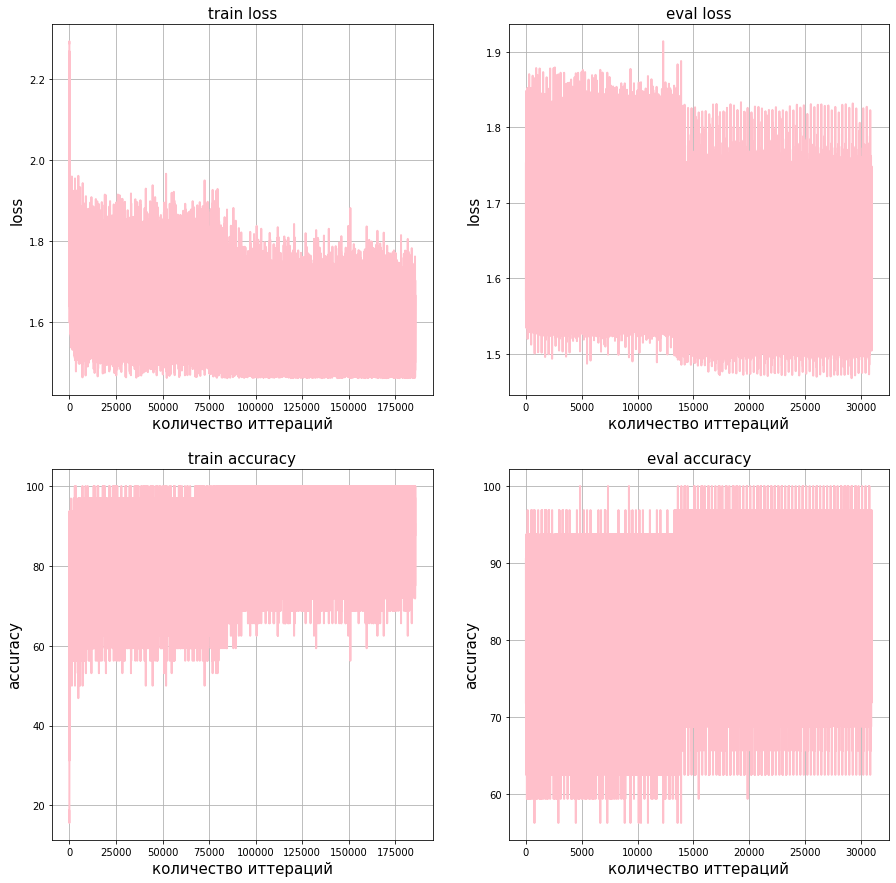

In [ ]:
fig, ax = plt.subplots(nrows=2, ncols=2, figsize=(15, 15))

# Для train loss:
plt.subplot(2, 2, 1)
plt.title('train loss', fontsize = 15)
plt.xlabel('количество иттераций', fontsize = 15)
plt.ylabel('loss', fontsize = 15)
steps_train = list(range(0, len(train_loss_it) + 1))[1:]
plt.plot(steps_train, train_loss_it, c = 'pink', linewidth = 2)
plt.grid()

# Для eval loss:
plt.subplot(2, 2, 2)
plt.title('eval loss', fontsize = 15)
plt.xlabel('количество иттераций', fontsize = 15)
plt.ylabel('loss', fontsize = 15)
steps_eval = list(range(0, len(eval_loss_it) + 1))[1:]
plt.plot(steps_eval, eval_loss_it, c = 'pink', linewidth = 2)
plt.grid()

# Для train accuracy:
plt.subplot(2, 2, 3)
plt.title('train accuracy', fontsize = 15)
plt.xlabel('количество иттераций', fontsize = 15)
plt.ylabel('accuracy', fontsize = 15)
steps_train = list(range(0, len(train_acc_it) + 1))[1:]
plt.plot(steps_train, train_acc_it, c = 'pink', linewidth = 2)
plt.grid()

# Для eval accuracy:
plt.subplot(2, 2, 4)
plt.title('eval accuracy', fontsize = 15)
plt.xlabel('количество иттераций', fontsize = 15)
plt.ylabel('accuracy', fontsize = 15)
steps_eval = list(range(0, len(eval_acc_it) + 1))[1:]
plt.plot(steps_eval, eval_acc_it, c = 'pink', linewidth = 2)
plt.grid()

plt.show()

И более общую картину по эпохам:

In [ ]:
def plot_history(train_history, val_history, title='loss'):
    plt.figure(figsize=(10,7))
    plt.title('{}'.format(title), fontsize = 15)
    plt.xlabel('количество эпох', fontsize = 15)
    plt.ylabel('{}'.format(title), fontsize = 15)
    steps = list(range(0, len(train_history) + 1))[1:]
    plt.plot(steps, train_history, c = 'pink', linewidth = 2, label='train')
    plt.plot(steps, val_history, c = 'deeppink', linewidth = 2, label='eval')
    plt.legend(loc='best')
    plt.grid()
    plt.show()

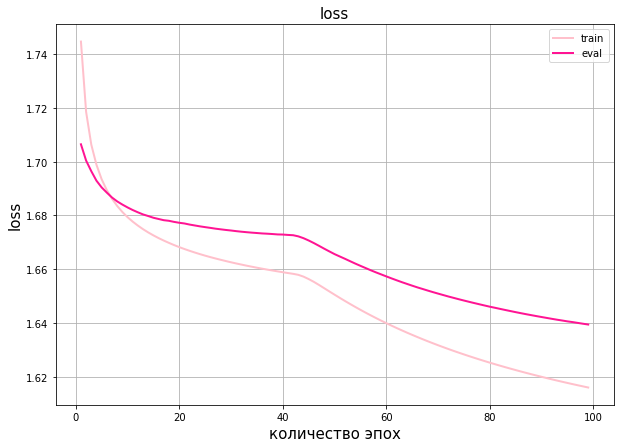

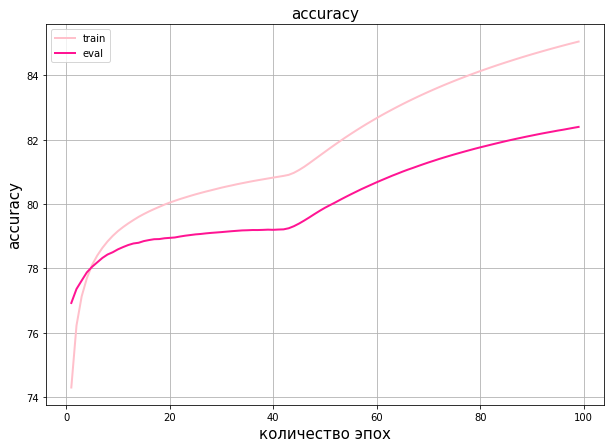

In [ ]:
plot_history(train_loss_ep, eval_loss_ep, 'loss')
plot_history(train_acc_ep, eval_acc_ep, 'accuracy')

**Вопросы к секции:**

* Своими словами и без математики объясните благодаря чему Adam дает несмещенную оценку на квадрат градиента

Благодаря выбору параметра $$\hat{v}= \frac{v}{1 - \beta_2^{t}}$$ оценка на квадраты градиента будет несмещенной (мат ожидание этого параметра = мат ожиданию квадрата градиента).

Адам адаптирует размеры шагов для каждого отдельного веса от оценки первого (m) и второго (v) моментов градиентов. Когда градиенты не сильно меняются и нам не нужно медленно спускаться по антиградиенту, размер шага имеет порядок $$\eta$$ Если градиенты сильно меняются и мы должны контролировать направление спуска (например, близко к локальныму минимуму), размер шага будет намного меньше.

* Когда модель начала переобучаться? Как вы это поняли? Сделайте визуализацию и докажите свою точку зрения.

Реализованное в адаме уменьшение размера шага на каждой итерации (step_size = lr / b1) сглаживает явное проявление переобучения.

Примерно между 40 и 45 эпохами возможно есть переобчуение - по графику видно, что loss там немного растет, а acc убывает. По цифрам тоже это наблюдалось:

Train: Iteration = 90000. Loss = 1.5657646656036377. Accuracy = 90.625.

Train: Iteration = 100000. Loss = 1.6144673824310303. Accuracy = 84.375.

Train: Iteration = 110000. Loss = 1.5282714366912842. Accuracy = 93.75.

Train: Iteration = 120000. Loss = 1.613065242767334. Accuracy = 87.5

# **Моя первая нейросеть (4 балла)**
В данной секции вам нужно сделать следующие вещи:

* Реализовать три разных архитектуры нейросетей. Эти архитектуры должны принципиально отличаться друг от друга. Разрешается одной из архитекур брать полностью полносвязную модель. Остальные две должны быть сверточными и сильно отличаться друг от друга. К примеру, одна из таких архитектур может быть VGG подобная сеть, а другая ResNet подобная архитектура.

* Написать цикл для обучения которым можно обучать все три модели без изменений кода

* Попробовать каждую модель с двумя оптимизаторами: RMSprop и SGD with momentum

* Визуализировать результаты перфоманса каждой модели (две метрики минимум для каждого сетапа, например, лосс и долю правильных ответов). В данном пункте мы ждем от вас визуализацию зависимости метрики от номера итерации обучения.

* Сделать выводы какие были модели были лучше и как вы думаете почему?

In [ ]:
NUM_EPOCH = 10

def train_model(model, dataloader, optimizer):
  train_loss_log = []
  train_acc_log = []
  val_loss_log = []
  val_acc_log = []
  train_dataloader, eval_dataloader = dataloader
  it = 0

  for epoch in range(NUM_EPOCH):
    model.train()
    train_loss = 0.
    train_size = 0
    train_acc = 0.
    for imgs, labels in train_dataloader:
      optimizer.zero_grad()
      y_pred = model(imgs)
      loss = nn.CrossEntropyLoss()(y_pred, labels)
      loss.backward()
      optimizer.step()
            
      train_loss += loss.item()
      train_size += y_pred.size(0)
      train_loss_log.append(loss.data)
      
      _, pred_classes = torch.max(y_pred, 1)
      correct = (pred_classes == labels).sum().item()
      train_acc += correct
      train_acc_log.append(100 * np.true_divide(correct, y_pred.size(0)))

      if it % 5000 == 0:
        print("Train: Iteration = {}. Loss = {}. Accuracy = {}.".format(it, train_loss_log[-1], train_acc_log[-1]))
      it += 1

    val_loss = 0.
    val_size = 0
    val_acc = 0.
    with torch.no_grad():
      for imgs, labels in eval_dataloader:
        pred = model(imgs)
        loss = nn.CrossEntropyLoss()(pred, labels)
        val_loss += loss.item()
        val_size += pred.size(0)

        _, pred_classes = torch.max(pred, 1)
        correct = (pred_classes == labels).sum().item()
        val_acc += correct
    val_loss_log.append(np.true_divide(val_loss, val_size))
    val_acc_log.append(100 * np.true_divide(val_acc, val_size))

  return val_loss_log, val_acc_log # Будем возвращать лосс и accuracy для тестовой выборки

In [ ]:
class FirstModel(nn.Module):
  def __init__(self):
    super(FirstModel, self).__init__()
    self.flatten = nn.Flatten()
    self.linear1 = nn.Linear(784, 128) # Полносвязные слои
    self.linear2 = nn.Linear(128, 64)
    self.linear3 = nn.Linear(64, 10)

  def forward(self, x):
    x = self.flatten(x) # превращаем картинку 28х28 в вектор размером 784
    x = F.relu(self.linear1(x)) 
    x = F.relu(self.linear2(x))
    x = self.linear3(x)
    return x   

model1 = FirstModel()
optimizer_rms_m1 = torch.optim.RMSprop(model1.parameters(), lr=0.001)
optimizer_sgd_m1 = torch.optim.SGD(model1.parameters(), lr=0.001, momentum=0.9)

In [ ]:
second_model = nn.Sequential(
    nn.Conv2d(1, 16, 3, padding=1), # Свёрточный слой
    nn.ReLU(),
    nn.Conv2d(16, 8, 3, padding=1),
    nn.ReLU(),
    nn.Conv2d(8, 4, 1, padding=1),
    nn.ReLU(),
    nn.MaxPool2d(2, 2),
    nn.Flatten(),
    nn.Linear(900, 128),
    nn.ReLU(),
    nn.Linear(128, 10),
    nn.Softmax(dim=-1)
)

optimizer_rms_m2 = torch.optim.RMSprop(second_model.parameters(), lr=0.001)
optimizer_sgd_m2 = torch.optim.SGD(second_model.parameters(), lr=0.001, momentum=0.9)

In [ ]:
def plot_optimizer(loss_RMS, acc_RMS, loss_SGD, acc_SGD): # Для сравнения 2 оптимизаторов в рамках одной модели
    fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(15, 15))

    # Для eval loss:
    plt.subplot(2, 2, 1)
    plt.title('MODEL 1 eval loss', fontsize = 15)
    plt.xlabel('epochs', fontsize = 15)
    plt.ylabel('loss', fontsize = 15)
    steps_eval = list(range(0, 11))[1:]
    plt.plot(steps_eval, loss_RMS, c = 'pink', label='RMS', linewidth = 2)
    plt.plot(steps_eval, loss_SGD, c = 'deeppink', label='SGD', linewidth = 2)
    plt.legend(loc='best')
    plt.grid()

    # Для eval accuracy:
    plt.subplot(2, 2, 2)
    plt.title('MODEL 1 eval accuracy', fontsize = 15)
    plt.xlabel('epochs', fontsize = 15)
    plt.ylabel('accuracy', fontsize = 15)
    steps_eval = list(range(0, 11))[1:]
    plt.plot(steps_eval, acc_RMS, c = 'pink', label='RMS', linewidth = 2)
    plt.plot(steps_eval, acc_SGD, c = 'deeppink', label='SGD', linewidth = 2)
    plt.legend(loc='best')
    plt.grid()

    plt.show()

**Результаты обучения 1 модели:**

In [ ]:
loss_m1_RMS, acc_m1_RMS = train_model(model1, [train_dataloader, eval_dataloader], optimizer_rms_m1)

Train: Iteration = 0. Loss = 2.2559187412261963. Accuracy = 12.5.
Train: Iteration = 5000. Loss = 0.06528376042842865. Accuracy = 100.0.
Train: Iteration = 10000. Loss = 0.21183279156684875. Accuracy = 93.75.
Train: Iteration = 15000. Loss = 0.036343201994895935. Accuracy = 100.0.
Train: Iteration = 20000. Loss = 0.528876781463623. Accuracy = 81.25.
Train: Iteration = 25000. Loss = 0.2039378434419632. Accuracy = 93.75.
Train: Iteration = 30000. Loss = 0.17803312838077545. Accuracy = 93.75.
Train: Iteration = 35000. Loss = 0.31525880098342896. Accuracy = 87.5.


In [ ]:
loss_m1_SGD, acc_m1_SGD = train_model(model1, [train_dataloader, eval_dataloader], optimizer_sgd_m1)

Train: Iteration = 0. Loss = 0.45905032753944397. Accuracy = 75.0.
Train: Iteration = 5000. Loss = 0.2259366810321808. Accuracy = 93.75.
Train: Iteration = 10000. Loss = 0.25237947702407837. Accuracy = 87.5.
Train: Iteration = 15000. Loss = 0.2337900698184967. Accuracy = 87.5.
Train: Iteration = 20000. Loss = 0.10663479566574097. Accuracy = 93.75.
Train: Iteration = 25000. Loss = 0.3093143701553345. Accuracy = 87.5.
Train: Iteration = 30000. Loss = 0.18748654425144196. Accuracy = 87.5.
Train: Iteration = 35000. Loss = 0.19317221641540527. Accuracy = 87.5.


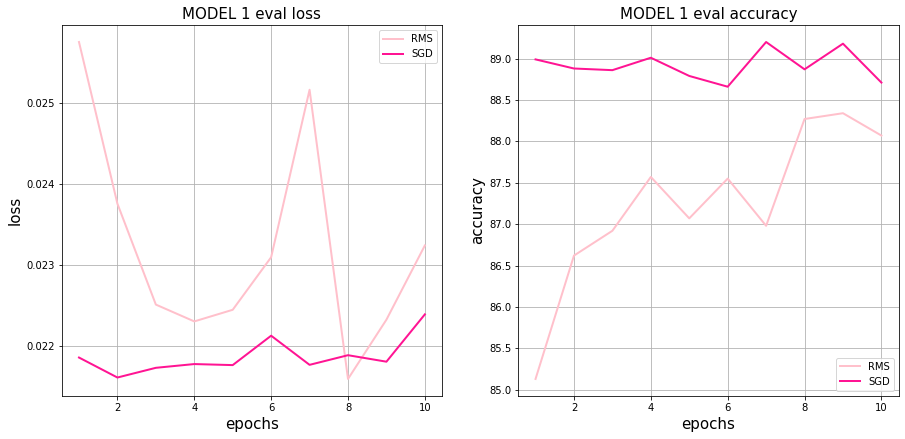

In [ ]:
plot_optimizer(loss_m1_RMS, acc_m1_RMS, loss_m1_SGD, acc_m1_SGD)

**Результаты обучения 2 модели:**

In [ ]:
loss_m2_RMS, acc_m2_RMS = train_model(second_model, [train_dataloader, eval_dataloader], optimizer_rms_m2)

Train: Iteration = 0. Loss = 2.304075241088867. Accuracy = 0.0.
Train: Iteration = 5000. Loss = 1.8456296920776367. Accuracy = 62.5.
Train: Iteration = 10000. Loss = 1.7100963592529297. Accuracy = 75.0.
Train: Iteration = 15000. Loss = 1.6562678813934326. Accuracy = 81.25.
Train: Iteration = 20000. Loss = 1.6899616718292236. Accuracy = 75.0.
Train: Iteration = 25000. Loss = 1.4634106159210205. Accuracy = 100.0.
Train: Iteration = 30000. Loss = 1.4654779434204102. Accuracy = 100.0.
Train: Iteration = 35000. Loss = 1.6470011472702026. Accuracy = 81.25.


In [ ]:
loss_m2_SGD, acc_m2_SGD = train_model(second_model, [train_dataloader, eval_dataloader], optimizer_sgd_m2)

Train: Iteration = 0. Loss = 1.4988868236541748. Accuracy = 100.0.
Train: Iteration = 5000. Loss = 1.5775647163391113. Accuracy = 87.5.
Train: Iteration = 10000. Loss = 1.461151361465454. Accuracy = 100.0.
Train: Iteration = 15000. Loss = 1.5239810943603516. Accuracy = 93.75.
Train: Iteration = 20000. Loss = 1.571789264678955. Accuracy = 87.5.
Train: Iteration = 25000. Loss = 1.5864671468734741. Accuracy = 87.5.
Train: Iteration = 30000. Loss = 1.5861499309539795. Accuracy = 87.5.
Train: Iteration = 35000. Loss = 1.5861502885818481. Accuracy = 87.5.


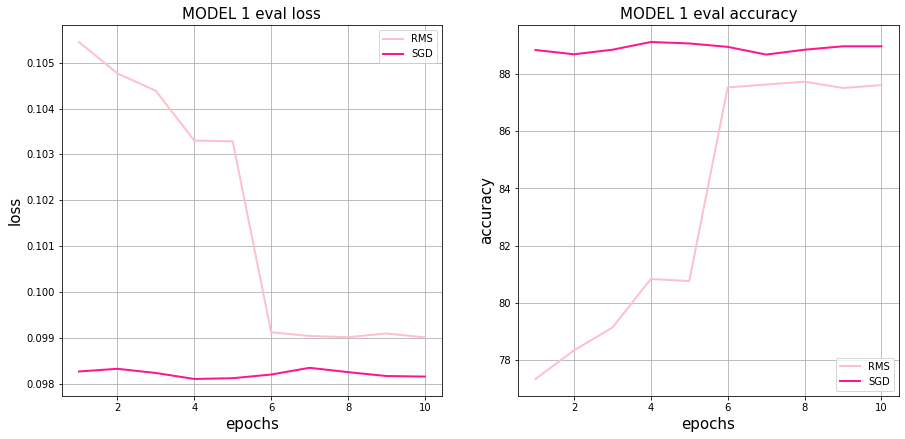

In [ ]:
plot_optimizer(loss_m2_RMS, acc_m2_RMS, loss_m2_SGD, acc_m2_SGD)

**Сравнение 1 и 2 моделей:**

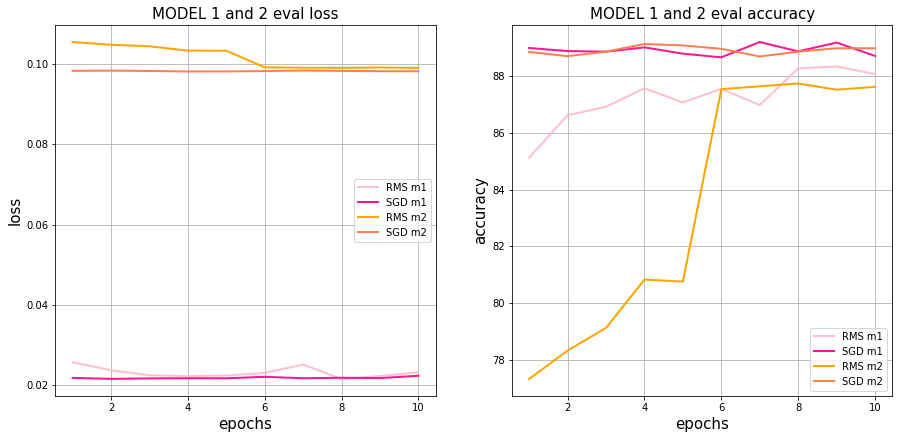

In [ ]:
fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(15, 15))

# Для eval loss:
plt.subplot(2, 2, 1)
plt.title('MODEL 1 and 2 eval loss', fontsize = 15)
plt.xlabel('epochs', fontsize = 15)
plt.ylabel('loss', fontsize = 15)
steps_eval = list(range(0, 11))[1:]
plt.plot(steps_eval, loss_m1_RMS, c = 'pink', label='RMS m1', linewidth = 2)
plt.plot(steps_eval, loss_m1_SGD, c = 'deeppink', label='SGD m1', linewidth = 2)
plt.plot(steps_eval, loss_m2_RMS, c = 'orange', label='RMS m2', linewidth = 2)
plt.plot(steps_eval, loss_m2_SGD, c = 'coral', label='SGD m2', linewidth = 2)
plt.legend(loc='best')
plt.grid()

# Для eval accuracy:
plt.subplot(2, 2, 2)
plt.title('MODEL 1 and 2 eval accuracy', fontsize = 15)
plt.xlabel('epochs', fontsize = 15)
plt.ylabel('accuracy', fontsize = 15)
steps_eval = list(range(0, 11))[1:]
plt.plot(steps_eval, acc_m1_RMS, c = 'pink', label='RMS m1', linewidth = 2)
plt.plot(steps_eval, acc_m1_SGD, c = 'deeppink', label='SGD m1', linewidth = 2)
plt.plot(steps_eval, acc_m2_RMS, c = 'orange', label='RMS m2', linewidth = 2)
plt.plot(steps_eval, acc_m2_SGD, c = 'coral', label='SGD m2', linewidth = 2)
plt.legend(loc='best')
plt.grid()

plt.show()

В рамках одной модели SGD с моментумом дает результат немного лучше, чем RMSprop (ниже loss и выше accuracy). Однако, начиная с 6 эпохи для второй модели и с 8 эпохи для первой, loss для обоих оптимизаторов очень близок. Аналогично и для accuracy, с увеличением кол-ва эпох оптимизаторы сближаются по значениям.

Идеологически должен быть лучше RMSprop, т.к. он является адаптивным градиентным спуском (подстраивают learning rate в зависимости от обучения).

loss для первой модели ниже, чем для второй для обоих оптимизаторов, accuracy же становится достаточно похожа с увеличением эпохи.

Vgg-подобна сеть лучше полность полносвязной сети, т.к. в добавок к линейным слоям она делает еще свертку картинки => у нейронов появляется receptive field, с помощью которых ищутся каки-то паттерны на картинке.